# Question 1 (Line and Memory Profiler with Old Code)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
System size 10x10: Avg time per MC cycle = 0.00045 seconds
System size 20x20: Avg time per MC cycle = 0.00186 seconds
System size 30x30: Avg time per MC cycle = 0.00418 seconds


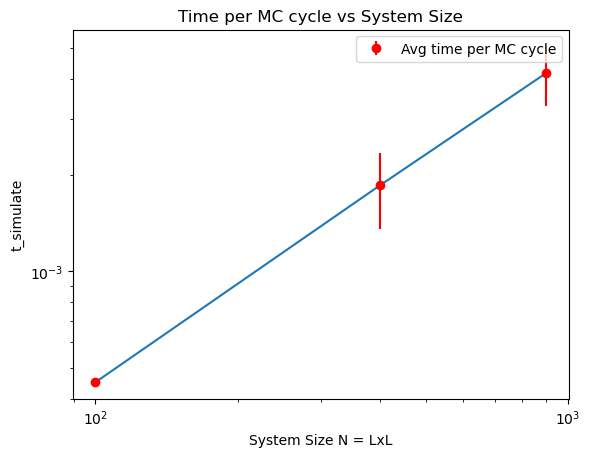

System size 10x10: Magnetization = 0.01270
System size 20x20: Magnetization = 0.00443
System size 30x30: Magnetization = -0.00185


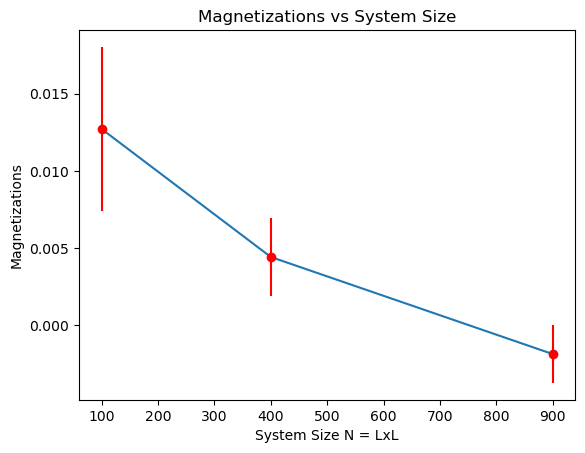

Timer unit: 1e-07 s

Total time: 0.899884 s
File: C:\Users\mo241\AppData\Local\Temp\ipykernel_14664\642771405.py
Function: simulate_ising at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
    24                                           def simulate_ising(L, init_state, T, J, N_mc, random_seed=None):
    25                                             '''
    26                                             A function that takes in a grid size, initial state, Temperature
    27                                             J, Monte Carlo steps, and random seed. This builds a 2D Ising model using the
    28                                             Metropolis algorithm.
    29                                           
    30                                             This function also calculates t_simulate, the time required per MC cycle.
    31                                             '''
    32                                           
    33         1    

In [33]:
#References

#[1]https://www.w3schools.com/python/ref_random_seed.asp
#[2]https://stackoverflow.com/questions/66425508/what-is-the-meaning-of-for-in-range
#[3]https://pythoninchemistry.org/sim_and_scat/important_considerations/pbc.html
#[4]https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
#[5]https://github.com/MrFuguDataScience/Python_Basics/blob/main/Python_Profiling.ipynb


#importing libraries
%pip install line_profiler
%pip install memory_profiler
%load_ext memory_profiler


import numpy as np
import matplotlib.pyplot as plt
import time
from line_profiler import LineProfiler
from memory_profiler import profile



def simulate_ising(L, init_state, T, J, N_mc, random_seed=None):
  '''
  A function that takes in a grid size, initial state, Temperature
  J, Monte Carlo steps, and random seed. This builds a 2D Ising model using the
  Metropolis algorithm.

  This function also calculates t_simulate, the time required per MC cycle.
  '''

  np.random.seed(random_seed) #initializing RNG [1]

  #First step is to initialize spins of ising grid
  # all_up = +1 , all_down = -1, random = +1 or -1
  if init_state == "all_up":
    state = np.ones((L,L))
  elif init_state == "all_down":
    state = -np.ones((L,L))
  elif init_state == "random":
    state = np.random.choice([-1,1], size=(L, L))

  #Initialize trajectory array and time spent per MC cycle array
  trajectory = []
  time_per_mcmove = []

  for step in range(N_mc):
    t_start = time.time()
    for _ in range(L*L):
      #picking a random spin with coordinates (i,j)
      i, j = np.random.randint(0, L), np.random.randint(0, L)  # Pick a random site
      # Uses the % operator to get periodic boundary conditions - position % L
      spin = state[i, j]
      #defining the neighbors
      neighbors = state[(i+1)%L, j] + state[(i-1)%L, j] + state[i, (j+1)%L] + state[i, (j-1)%L]  # Periodic boundary conditions [3]
      dE = 2*J*spin*neighbors
      if dE < 0 or np.random.rand() < np.exp(-dE / T):  # Metropolis criterion
        state[i, j] *= -1 # if conditional is met, spin is flipped
    t_end = time.time()
    time_per_mcmove.append(t_end - t_start) #expression to calculate the execution time of mc_move
    trajectory.append(state.copy())

  t_simulate = np.mean(time_per_mcmove) #averages the execution time from the 1500 MC steps

  return np.array(trajectory), t_simulate

'''def plot_state(trajectory, step):
  ising_grid = trajectory[step]

  plt.imshow(ising_grid, cmap='gray') #Purpose of imshow - each site (represented by a square) is denoted by an upspin or downspin [4]
  plt.title(f'Trajectory Plot at Step {step}')
  plt.colorbar(label ='spin')
  plt.show()
'''


def run_simulations(grid_size, T, J, N_mc):
  """
  Calculate t_simulate for each N (LxL)
  """

  times_per_cycle = []
  errors = []

  for L in grid_size:
    _, avg_time_per_cycle = simulate_ising(L, init_state = init_state, T=T, J=J, N_mc = N_mc, random_seed=random_seed)
    times_per_cycle.append(avg_time_per_cycle)

    #Standard error for t_simulate
    std_error = np.std(times_per_cycle) / np.sqrt(len(times_per_cycle))
    errors.append(std_error)

    print(f'System size {L}x{L}: Avg time per MC cycle = {avg_time_per_cycle:.5f} seconds')

  return grid_size, times_per_cycle, errors



def calc_magnetization(trajectory):
  """
  Calculate magnetization for each Ising grid
  """
  magnetization = []
  L = trajectory.shape[1]
  for state in trajectory:
    M = np.sum(state) / (L*L)
    magnetization.append(M)
  return np.array(magnetization)


def run_mag_calc(grid_size, N_mc, J, random_seed=None):
  '''
  #Calculate average magnetization for each N (LxL)

'''

  magnetizations_values = []
  magnetizations_errors = []

  for L in grid_size :
      #Simulate ising at current grid size
      trajectory, _ = simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed=random_seed)
      magnetization_all_steps = calc_magnetization(trajectory)

      #Updating magnetization array by getting rid of first 500 equilibration steps
      updated_magnetization = magnetization_all_steps[500:]

      #Average magnetization and standard deviation at each grid size
      avg_magnetization = np.mean(updated_magnetization)
      std_error = np.std(updated_magnetization) / np.sqrt(1000)

      #Store results
      magnetizations_values.append(avg_magnetization)
      magnetizations_errors.append(std_error)

      print(f'System size {L}x{L}: Magnetization = {avg_magnetization:.5f}')

  return magnetizations_values, magnetizations_errors


'''
def sweep(L, temperatures, N_mc, J, random_seed=None):

  #Sweep function performs the simulate_ising function for the entire
  #temperature range. It then calculates the average magnetization at each temperature that will
  #be needed for one of the plots.


  temperatures=[]
  magnetizations = []

  for T in temperature_range:
      #Simulate ising at current temperature
      trajectory = simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed=random_seed)

      #calculate magnetizations at each temperature
      mags = calc_magnetization(trajectory)
      #print(mags)

      #Average magnetization at current temperature
      avg_magnetization = np.mean(mags)
      #print(avg_magnetization)

      #Store results
      temperatures.append(T)
      magnetizations.append(avg_magnetization)

  return np.array(temperatures), np.array(magnetizations)

def plot_Mag_vs_Temp(temperatures, magnetizations):
  # Plot Magnetization vs Temperature
  plt.figure(figsize=(12, 5))
  plt.plot(temperatures, magnetizations, marker='o', linestyle='-', label = 'Average Magnetizations')
  plt.title("Magnetization vs Temperature")
  plt.xlabel("Temperature")
  plt.ylabel("Magnetization")
  plt.legend()
  plt.tight_layout()
  plt.show()


def plot_Mag_Time_Series(magnetization):
  #Plot Magnetization as Time Series
  plt.plot(magnetization)
  plt.xlabel('Monte Carlo Steps (Time)')
  plt.ylabel('Magnetization')
  plt.title('Magnetization vs Time at T = 2.27')
  plt.show()
'''


def plot_tsim_vs_N(L_values, t_sim, tsim_errors):
  N_values = np.array(L_values**2)
  plt.figure()
  plt.errorbar(N_values, t_sim, yerr=tsim_errors, fmt='o', color='r', label='Avg time per MC cycle')
  plt.plot(N_values, t_sim)
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('System Size N = LxL')
  plt.ylabel('t_simulate')
  plt.title('Time per MC cycle vs System Size')
  plt.legend()
  plt.show()

def plot_mag_vs_N(L_values, magnetizations_values, magnetizations_errors):
  N_values = np.array(L_values**2)
  plt.figure()
  plt.errorbar(N_values, magnetizations_values, yerr=magnetizations_errors, fmt='o', color='r')
  plt.plot(N_values, magnetizations_values)
  plt.xlabel('System Size N = LxL')
  plt.ylabel('Magnetizations')
  plt.title('Magnetizations vs System Size')
  plt.show()


#temperature_range = np.linspace(1, 4.0, 20)
init_state = "all_up" #initial state
grid_size = np.linspace(10,30,3, dtype=int) #grid size
J = 1.0
N_mc = 1500
T=5
random_seed = np.random.randint(0, N_mc)
step = np.random.randint(0, N_mc)


#Running functions for t_sim vs N
L_values, t_simulate, tsim_errors = run_simulations(grid_size, T, J, N_mc)
plot_tsim_vs_N(L_values, t_simulate, tsim_errors)

#Running functions for Mag vs N
mag_values, mag_errors = run_mag_calc(grid_size, N_mc, J, random_seed=random_seed)
plot_mag_vs_N(L_values, mag_values, mag_errors)



'''
# Plotting state functions near and not near critical temperature
trajectory_up = simulate_ising(L, init_state = 'all_up', T=1.5, J=1.0, N_mc=N_mc, random_seed=None) #mostly all have the same upspin and maintains magnetism
plot_state(trajectory_up, step)
trajectory_up_crit = simulate_ising(L, init_state = 'all_up', T=2.27, J=1.0, N_mc=N_mc, random_seed=None) #near the critical point and magnetism approaches 0
plot_state(trajectory_up_crit, step)
trajectory_up_after_crit = simulate_ising(L, init_state = 'all_up', T=4.0, J=1.0, N_mc=N_mc, random_seed=None) #magentism is near 0 and loses its magentic properties at high T
plot_state(trajectory_up_after_crit, step)

#Performing a sweep of temperature range and plotting Magnetization w/ temperature
temperatures, magnetizations = sweep(L, temperature_range, N_mc, J, random_seed)
plot_Mag_vs_Temp(temperatures, magnetizations)

#Plotting the Time Series Curve for Magnetization
trajectory_critical = simulate_ising(L, init_state = 'random', T=2.27, J=J, N_mc=N_mc, random_seed=None)
mag_at_tc = calc_magnetization(trajectory_critical)
plot_Mag_Time_Series(mag_at_tc)
'''


#Line profiler for simulate_ising function [5]
def lineprofile_simulation():

  l_profiler = LineProfiler()
  l_p_wrapper = l_profiler(simulate_ising)
  for L in grid_size:
      l_p_wrapper(L, init_state, T=T, J=J, N_mc=N_mc, random_seed = random_seed)
      l_profiler.print_stats()

#Memory profiler for simulate_ising function
@profile
def memoryprofile_simulation():
  for L in grid_size:
    simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed=random_seed)



lineprofile_simulation()
memoryprofile_simulation()



















# Question 2 (Improving Code with Strategies)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
System size 10x10: Avg time per MC cycle = 0.00021 seconds
System size 20x20: Avg time per MC cycle = 0.00081 seconds
System size 30x30: Avg time per MC cycle = 0.00183 seconds


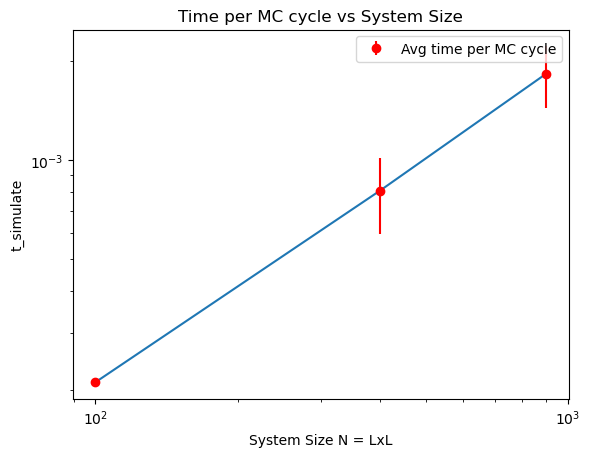

System size 10x10: Magnetization = 0.00140
System size 20x20: Magnetization = 0.00513
System size 30x30: Magnetization = -0.00511


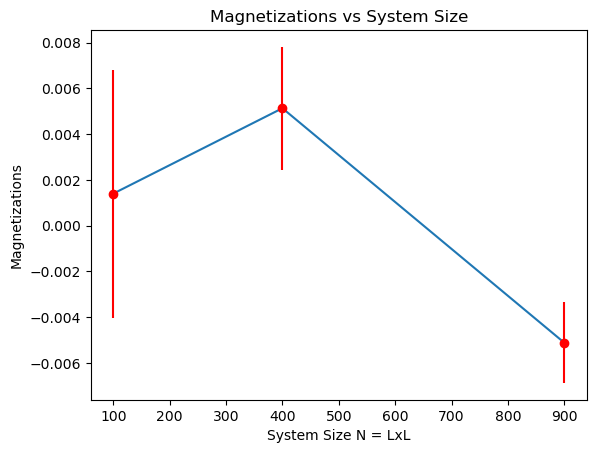

Timer unit: 1e-07 s

Total time: 0.524661 s
File: C:\Users\mo241\AppData\Local\Temp\ipykernel_14664\2680868888.py
Function: simulate_ising at line 23

Line #      Hits         Time  Per Hit   % Time  Line Contents
    23                                           def simulate_ising(L, init_state, T, J, N_mc, random_seed=None):
    24                                             '''
    25                                             A function that takes in a grid size, initial state, Temperature
    26                                             J, Monte Carlo steps, and random seed. This builds a 2D Ising model using the
    27                                             Metropolis algorithm.
    28                                           
    29                                             This function also calculates t_simulate, the time required per MC cycle.
    30                                             '''
    31         1        127.0    127.0      0.0    np.random.seed(ran

In [17]:
#References

#[1]https://www.w3schools.com/python/ref_random_seed.asp
#[2]https://stackoverflow.com/questions/66425508/what-is-the-meaning-of-for-in-range
#[3]https://pythoninchemistry.org/sim_and_scat/important_considerations/pbc.html
#[4]https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
#[5]https://github.com/MrFuguDataScience/Python_Basics/blob/main/Python_Profiling.ipynb


#importing libraries
%pip install line_profiler
%pip install memory_profiler


import numpy as np
import matplotlib.pyplot as plt
import time
from line_profiler import LineProfiler
from memory_profiler import profile



def simulate_ising(L, init_state, T, J, N_mc, random_seed=None):
  '''
  A function that takes in a grid size, initial state, Temperature
  J, Monte Carlo steps, and random seed. This builds a 2D Ising model using the
  Metropolis algorithm.

  This function also calculates t_simulate, the time required per MC cycle.
  '''
  np.random.seed(random_seed)

  #First step is to initialize spins of ising grid
  # all_up = +1 , all_down = -1, random = +1 or -1
  if init_state == "all_up":
    state = np.ones((L,L))
  elif init_state == "all_down":
    state = -np.ones((L,L))
  elif init_state == "random":
    state = np.random.choice([-1,1], size=(L, L))

  #Initialize trajectory array and time spent per MC cycle array

  beta = 1/T

  trajectory = np.zeros((N_mc, L, L))
  time_per_mcmove = np.zeros(N_mc)
  

  for step in range(N_mc):
    t_start = time.time()
   
    random_indices = np.random.randint(0, L, size=(L * L, 2))
    random_numbers = np.random.random((L * L))   #creating indices in bulk rather than each L*L step 

    for idx in range(L*L):
      #picking a random spin with coordinates (i,j)
      i, j = random_indices[idx]  
        
      # Uses the % operator to get periodic boundary conditions - position % L
      spin = state[i, j]
        
      #defining the neighbors
      neighbors = state[(i+1)%L, j] + state[(i-1)%L, j] + state[i, (j+1)%L] + state[i, (j-1)%L]  # Periodic boundary conditions [3]

      dE = 2 * J * spin * neighbors

      if dE < 0 or random_numbers[idx] < np.exp(-beta * dE):  # Metropolis criterion
        state[i,j] *= -1 # if conditional is met, spin is flipped
    t_end = time.time()
    #expression to calculate the execution time of mc_move
    time_per_mcmove[step] = t_end - t_start
    trajectory[step] = state.copy()
  t_simulate = np.mean(time_per_mcmove) #averages the execution time from the 1500 MC steps

  return trajectory, t_simulate

'''def plot_state(trajectory, step):
  ising_grid = trajectory[step]

  plt.imshow(ising_grid, cmap='gray') #Purpose of imshow - each site (represented by a square) is denoted by an upspin or downspin [4]
  plt.title(f'Trajectory Plot at Step {step}')
  plt.colorbar(label ='spin')
  plt.show()
'''

def run_simulations(grid_size, T, J, N_mc):
  """
  Calculate t_simulate for each N (LxL)
  """

  times_per_cycle = []
  errors = []

  for L in grid_size:
    _, avg_time_per_cycle = simulate_ising(L, init_state = init_state, T=T, J=J, N_mc = N_mc, random_seed=random_seed)
    times_per_cycle.append(avg_time_per_cycle)

    #Standard error for t_simulate
    std_error = np.std(times_per_cycle) / np.sqrt(len(times_per_cycle))
    errors.append(std_error)

    print(f'System size {L}x{L}: Avg time per MC cycle = {avg_time_per_cycle:.5f} seconds')

  return grid_size, times_per_cycle, errors



def calc_magnetization(trajectory):
  """
  Calculate magnetization for each Ising grid
  """
  magnetization = []
  L = trajectory.shape[1]
  for state in trajectory:
    M = np.sum(state) / (L*L)
    magnetization.append(M)
  return np.array(magnetization)



def run_mag_calc(grid_size, N_mc, J, random_seed=None):
  '''
  #Calculate average magnetization for each N (LxL)

'''

  magnetizations_values = []
  magnetizations_errors = []

  for L in grid_size :
      #Simulate ising at current grid size
      trajectory, _ = simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed=random_seed)
      magnetization_all_steps = calc_magnetization(trajectory)

      #Updating magnetization array by getting rid of first 500 equilibration steps
      updated_magnetization = magnetization_all_steps[500:]

      #Average magnetization and standard deviation at each grid size
      avg_magnetization = np.mean(updated_magnetization)
      std_error = np.std(updated_magnetization) / np.sqrt(1000)

      #Store results
      magnetizations_values.append(avg_magnetization)
      magnetizations_errors.append(std_error)

      print(f'System size {L}x{L}: Magnetization = {avg_magnetization:.5f}')

  return magnetizations_values, magnetizations_errors




'''def sweep(L, temperatures, N_mc, J, random_seed=None):

  #Sweep functions performs the simulate_ising function for the entire
  #temperature range. It then calculates the average magnetization at each temperature that will
  #be needed for one of the plots.


  temperatures=[]
  magnetizations = []

  for T in temperature_range:
      #Simulate ising at current temperature
      trajectory = simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed=random_seed)

      #calculate magnetizations at each temperature
      mags = calc_magnetization(trajectory)
      #print(mags)

      #Average magnetization at current temperaturer
      avg_magnetization = np.mean(mags)
      #print(avg_magnetization)

      #Store results
      temperatures.append(T)
      magnetizations.append(avg_magnetization)

  return np.array(temperatures), np.array(magnetizations)

def plot_Mag_vs_Temp(temperatures, magnetizations):
  # Plot Magnetization vs Temperature
  plt.figure(figsize=(12, 5))
  plt.plot(temperatures, magnetizations, marker='o', linestyle='-', label = 'Average Magnetizations')
  plt.title("Magnetization vs Temperature")
  plt.xlabel("Temperature")
  plt.ylabel("Magnetization")
  plt.legend()
  plt.tight_layout()
  plt.show()


def plot_Mag_Time_Series(magnetization):
  #Plot Magnetization as Time Series
  plt.plot(magnetization)
  plt.xlabel('Monte Carlo Steps (Time)')
  plt.ylabel('Magnetization')
  plt.title('Magnetization vs Time at T = 2.27')
  plt.show()
'''

def plot_tsim_vs_N(L_values, t_sim, tsim_errors):
  N_values = np.array(L_values**2)
  plt.figure()
  plt.errorbar(N_values, t_sim, yerr=tsim_errors, fmt='o', color='r', label='Avg time per MC cycle')
  plt.plot(N_values, t_sim)
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('System Size N = LxL')
  plt.ylabel('t_simulate')
  plt.title('Time per MC cycle vs System Size')
  plt.legend()
  plt.show()


def plot_mag_vs_N(L_values, magnetizations_values, magnetizations_errors):
  N_values = np.array(L_values**2)
  plt.figure()
  plt.errorbar(N_values, magnetizations_values, yerr=magnetizations_errors, fmt='o', color='r')
  plt.plot(N_values, magnetizations_values)
  plt.xlabel('System Size N = LxL')
  plt.ylabel('Magnetizations')
  plt.title('Magnetizations vs System Size')
  plt.show()


#temperature_range = np.linspace(1, 4.0, 20)
init_state = "all_up" #initial state
grid_size = np.linspace(10,30,3, dtype=int) #grid size
J = 1.0
N_mc = 1500
T=5

random_seed = np.random.randint(0, N_mc) #how to make it jax related??
step = np.random.randint(0, N_mc) #how to make it jax related??

#Running functions for t_sim vs N
L_values, t_simulate, tsim_errors = run_simulations(grid_size, T, J, N_mc)
plot_tsim_vs_N(L_values, t_simulate, tsim_errors)

#Running functions for Mag vs N
mag_values, mag_errors = run_mag_calc(grid_size, N_mc, J, random_seed=random_seed)
plot_mag_vs_N(L_values, mag_values, mag_errors)



'''
# Plotting state functions near and not near critical temperature
trajectory_up = simulate_ising(L, init_state = 'all_up', T=1.5, J=1.0, N_mc=N_mc, random_seed=None) #mostly all have the same upspin and maintains magnetism
plot_state(trajectory_up, step)
trajectory_up_crit = simulate_ising(L, init_state = 'all_up', T=2.27, J=1.0, N_mc=N_mc, random_seed=None) #near the critical point and magnetism approaches 0
plot_state(trajectory_up_crit, step)
trajectory_up_after_crit = simulate_ising(L, init_state = 'all_up', T=4.0, J=1.0, N_mc=N_mc, random_seed=None) #magentism is near 0 and loses its magentic properties at high T
plot_state(trajectory_up_after_crit, step)

#Performing a sweep of temperature range and plotting Magnetization w/ temperature
temperatures, magnetizations = sweep(L, temperature_range, N_mc, J, random_seed)
plot_Mag_vs_Temp(temperatures, magnetizations)

#Plotting the Time Series Curve for Magnetization
trajectory_critical = simulate_ising(L, init_state = 'random', T=2.27, J=J, N_mc=N_mc, random_seed=None)
mag_at_tc = calc_magnetization(trajectory_critical)
plot_Mag_Time_Series(mag_at_tc)
'''


#Line profiler for simulate_ising function [5]
def lineprofile_simulation():

  l_profiler = LineProfiler()
  l_p_wrapper = l_profiler(simulate_ising)
  for L in grid_size:
      l_p_wrapper(L, init_state, T=T, J=J, N_mc=N_mc, random_seed = random_seed)
      l_profiler.print_stats()

#Memory profiler for simulate_ising function
'''def memoryprofile_simulation():
    if __name__ == "__main__":
        simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed = random_seed)
'''


lineprofile_simulation()
#memoryprofile_simulation()

# Question 3 (Checkerboard Algorithm)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
System size 10x10: Avg time per MC cycle = 0.00014 seconds
System size 20x20: Avg time per MC cycle = 0.00055 seconds
System size 30x30: Avg time per MC cycle = 0.00125 seconds


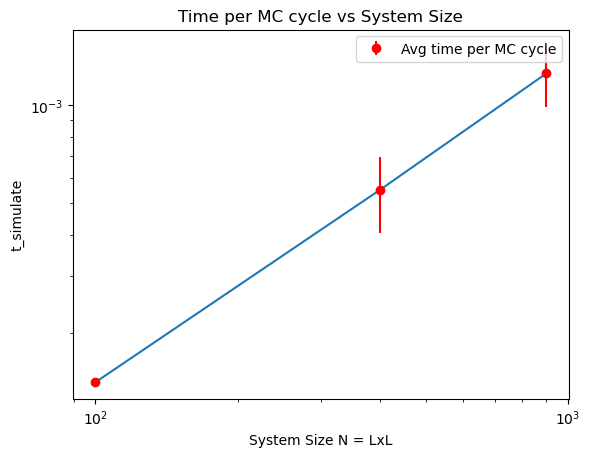

System size 10x10: Magnetization = 0.02550
System size 20x20: Magnetization = 0.01715
System size 30x30: Magnetization = -0.01207


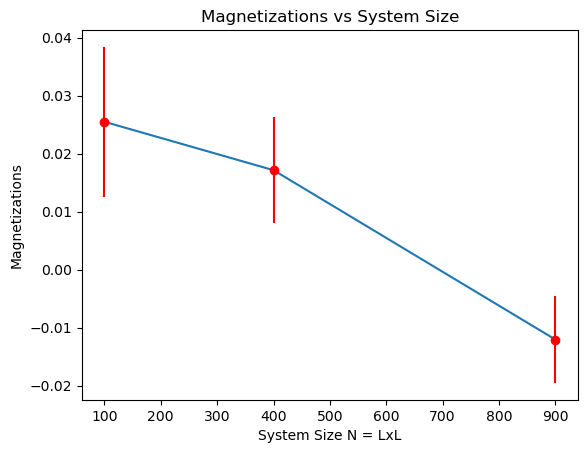

Timer unit: 1e-07 s

Total time: 0.463946 s
File: C:\Users\mo241\AppData\Local\Temp\ipykernel_14664\143498565.py
Function: simulate_ising at line 23

Line #      Hits         Time  Per Hit   % Time  Line Contents
    23                                           def simulate_ising(L, init_state, T, J, N_mc, random_seed=None):
    24                                             '''
    25                                             A function that takes in a grid size, initial state, Temperature
    26                                             J, Monte Carlo steps, and random seed. This builds a 2D Ising model using the
    27                                             Metropolis algorithm.
    28                                           
    29                                             This function also calculates t_simulate, the time required per MC cycle.
    30                                             '''
    31         1        119.0    119.0      0.0    np.random.seed(rand

In [28]:
#References

#[1]https://www.w3schools.com/python/ref_random_seed.asp
#[2]https://stackoverflow.com/questions/66425508/what-is-the-meaning-of-for-in-range
#[3]https://pythoninchemistry.org/sim_and_scat/important_considerations/pbc.html
#[4]https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
#[5]https://github.com/MrFuguDataScience/Python_Basics/blob/main/Python_Profiling.ipynb


#importing libraries
%pip install line_profiler
%pip install memory_profiler


import numpy as np
import matplotlib.pyplot as plt
import time
from line_profiler import LineProfiler
from memory_profiler import profile



def simulate_ising(L, init_state, T, J, N_mc, random_seed=None):
  '''
  A function that takes in a grid size, initial state, Temperature
  J, Monte Carlo steps, and random seed. This builds a 2D Ising model using the
  Metropolis algorithm.

  This function also calculates t_simulate, the time required per MC cycle.
  '''
  np.random.seed(random_seed)

  #First step is to initialize spins of ising grid
  # all_up = +1 , all_down = -1, random = +1 or -1
  if init_state == "all_up":
    state = np.ones((L,L))
  elif init_state == "all_down":
    state = -np.ones((L,L))
  elif init_state == "random":
    state = np.random.choice([-1,1], size=(L, L))

  #Initialize trajectory array and time spent per MC cycle array

  beta = 1/T

  trajectory = np.zeros((N_mc, L, L))
  time_per_mcmove = np.zeros(N_mc)
  

  for step in range(N_mc):
    t_start = time.time()
   
    random_numbers = np.random.random((L * L))

    #Checkerboard algorithm (grouping black and white grids together)
    for checkerboard in [0, 1]:  # First update "black" cells (i + j is even), then "white" cells (i + j is odd)
      for i in range(L):
        for j in range(L):
          if (i + j) % 2 == checkerboard:
            # Pick the spin (i, j)
            spin = state[i, j]

            # Calculate the sum of neighboring spins using periodic boundary conditions
            neighbors = (state[(i + 1) % L, j] + state[(i - 1) % L, j] + state[i, (j + 1) % L] + state[i, (j - 1) % L])

            # Calculate energy change if we flip this spin
            dE = 2 * J * spin * neighbors

            # Apply the Metropolis criterion
            if dE < 0 or random_numbers[j] < np.exp(-beta * dE):
              state[i, j] *= -1  # Flip the spin
    t_end = time.time()
    #expression to calculate the execution time of mc_move
    time_per_mcmove[step] = t_end - t_start
    trajectory[step] = state.copy()
  t_simulate = np.mean(time_per_mcmove) #averages the execution time from the 1500 MC steps

  return trajectory, t_simulate

'''def plot_state(trajectory, step):
  ising_grid = trajectory[step]

  plt.imshow(ising_grid, cmap='gray') #Purpose of imshow - each site (represented by a square) is denoted by an upspin or downspin [4]
  plt.title(f'Trajectory Plot at Step {step}')
  plt.colorbar(label ='spin')
  plt.show()
'''

def run_simulations(grid_size, T, J, N_mc):
  """
  Calculate t_simulate for each N (LxL)
  """

  times_per_cycle = []
  errors = []

  for L in grid_size:
    _, avg_time_per_cycle = simulate_ising(L, init_state = init_state, T=T, J=J, N_mc = N_mc, random_seed=random_seed)
    times_per_cycle.append(avg_time_per_cycle)

    #Standard error for t_simulate
    std_error = np.std(times_per_cycle) / np.sqrt(len(times_per_cycle))
    errors.append(std_error)

    print(f'System size {L}x{L}: Avg time per MC cycle = {avg_time_per_cycle:.5f} seconds')

  return grid_size, times_per_cycle, errors



def calc_magnetization(trajectory):
  """
  Calculate magnetization for each Ising grid
  """
  magnetization = []
  L = trajectory.shape[1]
  for state in trajectory:
    M = np.sum(state) / (L*L)
    magnetization.append(M)
  return np.array(magnetization)



def run_mag_calc(grid_size, N_mc, J, random_seed=None):
  '''
  #Calculate average magnetization for each N (LxL)

'''

  magnetizations_values = []
  magnetizations_errors = []

  for L in grid_size :
      #Simulate ising at current grid size
      trajectory, _ = simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed=random_seed)
      magnetization_all_steps = calc_magnetization(trajectory)

      #Updating magnetization array by getting rid of first 500 equilibration steps
      updated_magnetization = magnetization_all_steps[500:]

      #Average magnetization and standard deviation at each grid size
      avg_magnetization = np.mean(updated_magnetization)
      std_error = np.std(updated_magnetization) / np.sqrt(1000)

      #Store results
      magnetizations_values.append(avg_magnetization)
      magnetizations_errors.append(std_error)

      print(f'System size {L}x{L}: Magnetization = {avg_magnetization:.5f}')

  return magnetizations_values, magnetizations_errors




'''def sweep(L, temperatures, N_mc, J, random_seed=None):

  #Sweep functions performs the simulate_ising function for the entire
  #temperature range. It then calculates the average magnetization at each temperature that will
  #be needed for one of the plots.


  temperatures=[]
  magnetizations = []

  for T in temperature_range:
      #Simulate ising at current temperature
      trajectory = simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed=random_seed)

      #calculate magnetizations at each temperature
      mags = calc_magnetization(trajectory)
      #print(mags)

      #Average magnetization at current temperature
      avg_magnetization = np.mean(mags)
      #print(avg_magnetization)

      #Store results
      temperatures.append(T)
      magnetizations.append(avg_magnetization)

  return np.array(temperatures), np.array(magnetizations)

def plot_Mag_vs_Temp(temperatures, magnetizations):
  # Plot Magnetization vs Temperature
  plt.figure(figsize=(12, 5))
  plt.plot(temperatures, magnetizations, marker='o', linestyle='-', label = 'Average Magnetizations')
  plt.title("Magnetization vs Temperature")
  plt.xlabel("Temperature")
  plt.ylabel("Magnetization")
  plt.legend()
  plt.tight_layout()
  plt.show()


def plot_Mag_Time_Series(magnetization):
  #Plot Magnetization as Time Series
  plt.plot(magnetization)
  plt.xlabel('Monte Carlo Steps (Time)')
  plt.ylabel('Magnetization')
  plt.title('Magnetization vs Time at T = 2.27')
  plt.show()
'''

def plot_tsim_vs_N(L_values, t_sim, tsim_errors):
  N_values = np.array(L_values**2)
  plt.figure()
  plt.errorbar(N_values, t_sim, yerr=tsim_errors, fmt='o', color='r', label='Avg time per MC cycle')
  plt.plot(N_values, t_sim)
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('System Size N = LxL')
  plt.ylabel('t_simulate')
  plt.title('Time per MC cycle vs System Size')
  plt.legend()
  plt.show()


def plot_mag_vs_N(L_values, magnetizations_values, magnetizations_errors):
  N_values = np.array(L_values**2)
  plt.figure()
  plt.errorbar(N_values, magnetizations_values, yerr=magnetizations_errors, fmt='o', color='r')
  plt.plot(N_values, magnetizations_values)
  plt.xlabel('System Size N = LxL')
  plt.ylabel('Magnetizations')
  plt.title('Magnetizations vs System Size')
  plt.show()


#temperature_range = np.linspace(1, 4.0, 20)
init_state = "all_up" #initial state
grid_size = np.linspace(10,30,3, dtype=int) #grid size
J = 1.0
N_mc = 1500
T=5

random_seed = np.random.randint(0, N_mc) #how to make it jax related??
step = np.random.randint(0, N_mc) #how to make it jax related??

#Running functions for t_sim vs N
L_values, t_simulate, tsim_errors = run_simulations(grid_size, T, J, N_mc)
plot_tsim_vs_N(L_values, t_simulate, tsim_errors)

#Running functions for Mag vs N
mag_values, mag_errors = run_mag_calc(grid_size, N_mc, J, random_seed=random_seed)
plot_mag_vs_N(L_values, mag_values, mag_errors)



'''
# Plotting state functions near and not near critical temperature
trajectory_up = simulate_ising(L, init_state = 'all_up', T=1.5, J=1.0, N_mc=N_mc, random_seed=None) #mostly all have the same upspin and maintains magnetism
plot_state(trajectory_up, step)
trajectory_up_crit = simulate_ising(L, init_state = 'all_up', T=2.27, J=1.0, N_mc=N_mc, random_seed=None) #near the critical point and magnetism approaches 0
plot_state(trajectory_up_crit, step)
trajectory_up_after_crit = simulate_ising(L, init_state = 'all_up', T=4.0, J=1.0, N_mc=N_mc, random_seed=None) #magentism is near 0 and loses its magentic properties at high T
plot_state(trajectory_up_after_crit, step)

#Performing a sweep of temperature range and plotting Magnetization w/ temperature
temperatures, magnetizations = sweep(L, temperature_range, N_mc, J, random_seed)
plot_Mag_vs_Temp(temperatures, magnetizations)

#Plotting the Time Series Curve for Magnetization
trajectory_critical = simulate_ising(L, init_state = 'random', T=2.27, J=J, N_mc=N_mc, random_seed=None)
mag_at_tc = calc_magnetization(trajectory_critical)
plot_Mag_Time_Series(mag_at_tc)
'''


#Line profiler for simulate_ising function [5]
def lineprofile_simulation():

  l_profiler = LineProfiler()
  l_p_wrapper = l_profiler(simulate_ising)
  for L in grid_size:
      l_p_wrapper(L, init_state, T=T, J=J, N_mc=N_mc, random_seed = random_seed)
      l_profiler.print_stats()

#Memory profiler for simulate_ising function
'''def memoryprofile_simulation():
    if __name__ == "__main__":
        simulate_ising(L, init_state, T=T, J=J, N_mc=N_mc, random_seed = random_seed)
'''


lineprofile_simulation()
#memoryprofile_simulation()